In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
mu0, sigma0 = [-2.,3.], [[1,np.cov([1,2])],[np.cov([1,2]),2]]
mu1, sigma1 = [3.,-2], [[2,np.cov([2,1])],[np.cov([2,1]),1]]

In [3]:
def sample(d0, d1, n=32,m=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0), torch.tensor(sigma0, dtype=torch.float32))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1), torch.tensor(sigma1, dtype=torch.float32))

In [5]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([0.3015, 0.6937]), tensor(-0.5241)]


In [6]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
   # out = torch.sigmoid(layer(x))
   # loss = F.binary_cross_entropy(out, y)
    loss = F.binary_cross_entropy_with_logits(layer(x), y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 1.401753
Ошибка после 1 итераций: 0.272501
Ошибка после 2 итераций: 0.137123
Ошибка после 3 итераций: 0.092590
Ошибка после 4 итераций: 0.070950
Ошибка после 5 итераций: 0.057425
Ошибка после 6 итераций: 0.048713
Ошибка после 7 итераций: 0.042718
Ошибка после 8 итераций: 0.038164
Ошибка после 9 итераций: 0.034228
Ошибка после 10 итераций: 0.031517
Ошибка после 11 итераций: 0.028885
Ошибка после 12 итераций: 0.027077
Ошибка после 13 итераций: 0.025105
Ошибка после 14 итераций: 0.023700
Ошибка после 15 итераций: 0.022305
Ошибка после 16 итераций: 0.021259
Ошибка после 17 итераций: 0.020415
Ошибка после 18 итераций: 0.019375
Ошибка после 19 итераций: 0.018613


In [47]:
x_scale = np.linspace(-10, 10, 2000)
y_scale = np.linspace(-10, 10, 2000)
X, Y = np.meshgrid(x_scale, y_scale)
pos = np.dstack((X, Y))
d0_pdf = stats.multivariate_normal.pdf(pos, mu0, sigma0) 
d1_pdf = stats.multivariate_normal.pdf(pos, mu1, sigma1)
xy_tensor = torch.tensor(pos, dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(xy_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

C:\Users\123\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


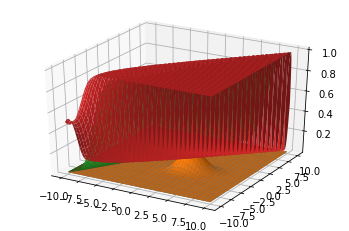

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, d0_pdf*2,label='d0')
ax.plot_surface(X, Y, d1_pdf*2,label='d1')
ax.plot_surface(X, Y, dist.reshape(2000,2000), label='pred')
ax.plot_surface(X, Y, ratio, label='ratio')
fig.show()

In [33]:
d0_pdf

array([[1.35538456e-25, 1.43095334e-25, 1.51056260e-25, ...,
        1.47259634e-77, 1.23716907e-77, 1.03926118e-77],
       [1.42690950e-25, 1.50650921e-25, 1.59036740e-25, ...,
        1.64142867e-77, 1.37904923e-77, 1.15847814e-77],
       [1.50212297e-25, 1.58596379e-25, 1.67429262e-25, ...,
        1.82951287e-77, 1.53711248e-77, 1.29129700e-77],
       ...,
       [1.67213630e-30, 1.86912788e-30, 2.08908769e-30, ...,
        6.21842853e-33, 5.53134038e-33, 4.91960730e-33],
       [1.57035113e-30, 1.75540177e-30, 1.96203436e-30, ...,
        6.18315515e-33, 5.50012173e-33, 4.89198116e-33],
       [1.47467741e-30, 1.64850097e-30, 1.84260270e-30, ...,
        6.14773019e-33, 5.46876646e-33, 4.86423191e-33]])

In [48]:
dist.reshape(2000,2000)

array([[6.3495147e-03, 6.4305854e-03, 6.5126778e-03, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [6.2984559e-03, 6.3788788e-03, 6.4603151e-03, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [6.2478045e-03, 6.3275849e-03, 6.4083710e-03, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       ...,
       [5.7357258e-10, 5.8094385e-10, 5.8840877e-10, ..., 9.8549139e-01,
        9.8567271e-01, 9.8585200e-01],
       [5.6893101e-10, 5.7624266e-10, 5.8364713e-10, ..., 9.8537469e-01,
        9.8555762e-01, 9.8573816e-01],
       [5.6432697e-10, 5.7157951e-10, 5.7892408e-10, ..., 9.8525709e-01,
        9.8544145e-01, 9.8562348e-01]], dtype=float32)

In [32]:
ratio

array([[5.00000000e-01, 4.99292507e-01, 4.98599318e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.00707493e-01, 5.00000000e-01, 4.99306807e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.01400682e-01, 5.00693193e-01, 5.00000000e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [8.80667643e-48, 8.78178902e-48, 8.75747284e-48, ...,
        5.00000000e-01, 5.27820864e-01, 5.55484116e-01],
       [7.87829576e-48, 7.85603192e-48, 7.83427910e-48, ...,
        4.72179136e-01, 5.00000000e-01, 5.27835119e-01],
       [7.04737983e-48, 7.02746413e-48, 7.00800557e-48, ...,
        4.44515884e-01, 4.72164881e-01, 5.00000000e-01]])